In [2]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torchvision.models import resnet50
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, output_dim=768):
        super().__init__()

        resnet = resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, output_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class CrossAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** -0.5

    def forward(self, x, y):
        q = self.query(x)
        k = self.key(y)
        v = self.value(y)

        attention = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attention = torch.softmax(attention, dim=-1)
        out = torch.matmul(attention, v)
        return out

class VQAModel(nn.Module):
    def __init__(self, num_classes=2, hidden_dim=768):
        super().__init__()

        self.resnet_features = ResNetFeatureExtractor(output_dim=hidden_dim)

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_projection = nn.Linear(768, hidden_dim)

        self.fusion = CrossAttention(hidden_dim)

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, image, question_ids, attention_mask):
        # process image
        image_features = self.resnet_features(image)

        # process question
        question_output = self.bert(question_ids, attention_mask=attention_mask)
        question_features = self.bert_projection(question_output.last_hidden_state)

        # fusion through cross-attention
        fused_features = self.fusion(question_features, image_features.unsqueeze(1))

        # attention mechanism
        attention_weights = self.attention(fused_features)
        attention_weights = torch.softmax(attention_weights, dim=1)
        attended_features = (fused_features * attention_weights).sum(dim=1)

        # generate output prediction
        logits = self.classifier(attended_features)
        return logits

def preprocess_image():
    return Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def preprocess_question(question: str, max_length: int = 64):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokens = tokenizer(
        question,
        padding='max_length',
        max_length=max_length,
        truncation=True,
        return_tensors='pt'
    )
    return tokens

class ShapeGenerator:
    def __init__(self, img_size=(224,224), noise=0):
        self.img_size = img_size
        self.shapes = ['circle', 'square', 'triangle']
        self.colors = {
            'red': (255, 0, 0),
            'blue': (0, 0, 255),
            'green': (0, 255, 0)
        }
        self.positions = ['above', 'below', 'left of', 'right of']
        self.shape_size = 40
        self.noise = noise

    def __shape__(self, draw, shape, color, pos):
        if shape == 'circle':
            draw.ellipse([pos[0]-self.shape_size//2,
                         pos[1]-self.shape_size//2,
                         pos[0]+self.shape_size//2,
                         pos[1]+self.shape_size//2],
                         fill=self.colors[color])
        elif shape == 'square':
            draw.rectangle([pos[0]-self.shape_size//2,
                          pos[1]-self.shape_size//2,
                          pos[0]+self.shape_size//2,
                          pos[1]+self.shape_size//2],
                          fill=self.colors[color])
        elif shape == 'triangle':
            points = [
                (pos[0], pos[1]-self.shape_size//2),
                (pos[0]-self.shape_size//2, pos[1]+self.shape_size//2),
                (pos[0]+self.shape_size//2, pos[1]+self.shape_size//2)
            ]
            draw.polygon(points, fill=self.colors[color])

    def __spatial__(self, pos1, pos2, rel):
        if rel == 'above':
            return pos1[1] < pos2[1]
        elif rel == 'below':
            return pos1[1] > pos2[1]
        elif rel == 'left of':
            return pos1[0] < pos2[0]
        elif rel == 'right of':
            return pos1[0] > pos2[0]

    def generate_sample(self):
        img = Image.new('RGB', self.img_size, 'white')
        draw = ImageDraw.Draw(img)

        shape1 = np.random.choice(self.shapes)
        shape2 = np.random.choice(self.shapes)
        color1 = np.random.choice(list(self.colors.keys()))
        color2 = np.random.choice(list(self.colors.keys()))
        position = np.random.choice(self.positions)

        margin = self.shape_size
        if position in ['above', 'below']:
            x1 = np.random.randint(margin, self.img_size[0]-margin)
            x2 = np.random.randint(margin, self.img_size[0]-margin)
            if position == 'above':
                y1 = self.img_size[1]//3
                y2 = 2*self.img_size[1]//3
            else:
                y1 = 2*self.img_size[1]//3
                y2 = self.img_size[1]//3
        else:  # left or right
            y1 = np.random.randint(margin, self.img_size[1]-margin)
            y2 = np.random.randint(margin, self.img_size[1]-margin)
            if position == 'left of':
                x1 = self.img_size[0]//3
                x2 = 2*self.img_size[0]//3
            else:
                x1 = 2*self.img_size[0]//3
                x2 = self.img_size[0]//3

        self.__shape__(draw, shape1, color1, (x1, y1))
        self.__shape__(draw, shape2, color2, (x2, y2))

        question = f"Is there a {color1} {shape1} {position} a {color2} {shape2}?"
        answer = 'yes' if self.__spatial__((x1, y1), (x2, y2), position) else 'no'

        return img, question, answer

class ShapesDataset(Dataset):
    def __init__(self, num_samples=1000, transform=None, split='train', noise=(0,0,0)):
        self.transform = transform
        self.generator = ShapeGenerator(noise=noise)
        self.n = num_samples
        self.data = []
        self.noise_indices = []
        self.tv_noise = noise[0]
        self.shape_noise = noise[1]
        self.color_noise = noise[2]

        for i in tqdm(range(self.n)):
            img, ques, ans = self.generator.generate_sample()

            if np.random.rand() < self.tv_noise:
                img = self.__tv_noise__(img)
                self.noise_indices.append(i)

            if np.random.rand() < self.shape_noise:
                ques = self.__shape_noise__(ques)
                ans = 'no'
                self.noise_indices.append(i)
            if np.random.rand() < self.color_noise:
                ques = self.__color_noise__(ques)
                ans = 'no'
                self.noise_indices.append(i)

            self.data.append((img, ques, ans))

        self.ans2idx = {'yes':0, 'no':1}

    def __tv_noise__(self, img):
        np_img = np.array(img)
        noise = np.random.randint(0, 64, (np_img.shape[0], np_img.shape[1], np_img.shape[2]), dtype='uint8')
        np_img = np.clip(np_img + noise, 0, 255)
        return Image.fromarray(np_img)

    def __shape_noise__(self, ques):
        shapes = ['circle', 'square', 'triangle']
        current_shape = [shape for shape in shapes if shape in ques][0]
        new_shape = np.random.choice([s for s in shapes if s != current_shape])
        return ques.replace(current_shape, new_shape)

    def __color_noise__(self, ques):
        colors = ['red', 'blue', 'green']
        current_color = [color for color in colors if color in ques][0]
        new_color = np.random.choice([c for c in colors if c != current_color])
        return ques.replace(current_color, new_color)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        img, ques, ans = self.data[idx]

        if self.transform:
            img = self.transform(img)

        return {
            'image' : img,
            'question' : ques,
            'answer' : torch.tensor(self.ans2idx[ans], dtype=torch.long)
        }

    def visualise_sample(self, idx):
        img, ques, ans = self.data[idx]
        plt.figure(figsize=(10,5))
        plt.imshow(img)
        plt.title(f"Q : {ques}\nA: {ans}")
        plt.axis('off')
        plt.show()

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc='Training'):
        images = batch['image'].to(device)
        questions = batch['question']
        answers = batch['answer'].to(device)

        # process questions through BERT tokenizer
        question_tokens = tokenizer(questions, padding=True, truncation=True,
                                  return_tensors='pt').to(device)

        optimizer.zero_grad()
        outputs = model(images, question_tokens.input_ids,
                       question_tokens.attention_mask)

        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += answers.size(0)
        correct += predicted.eq(answers).sum().item()

    return total_loss / len(dataloader), 100. * correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validating'):
            images = batch['image'].to(device)
            questions = batch['question']
            answers = batch['answer'].to(device)

            question_tokens = tokenizer(questions, padding=True, truncation=True,
                                      return_tensors='pt').to(device)

            outputs = model(images, question_tokens.input_ids,
                          question_tokens.attention_mask)
            loss = criterion(outputs, answers)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += answers.size(0)
            correct += predicted.eq(answers).sum().item()

    return total_loss / len(dataloader), 100. * correct / total

# define the image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


# initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if __name__ == '__main__':
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(0.1,0.1,0.1))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(0.1,0.1,0.1))

    # dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # initialize model and training components
    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # training loop with validation
    best_acc = 0
    test_accs = []
    test_losses = []
    train_accs = []
    train_losses = []
    for epoch in range(10):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        test_accs.append(test_acc)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')

Validating: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


Epoch 1:
Train Loss: 0.5027, Train Acc: 79.80%
Test Loss: 0.5520, Test Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 2:
Train Loss: 0.4803, Train Acc: 81.90%
Test Loss: 0.5836, Test Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch 3:
Train Loss: 0.4625, Train Acc: 81.90%
Test Loss: 0.5836, Test Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 4:
Train Loss: 0.4694, Train Acc: 81.90%
Test Loss: 0.5629, Test Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch 5:
Train Loss: 0.4604, Train Acc: 81.90%
Test Loss: 0.6990, Test Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


Epoch 6:
Train Loss: 0.4474, Train Acc: 81.90%
Test Loss: 0.5679, Test Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]


Epoch 7:
Train Loss: 0.4291, Train Acc: 81.90%
Test Loss: 0.5753, Test Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch 8:
Train Loss: 0.4329, Train Acc: 81.90%
Test Loss: 0.7413, Test Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch 9:
Train Loss: 0.3879, Train Acc: 81.80%
Test Loss: 0.7386, Test Acc: 72.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]

Epoch 10:
Train Loss: 0.3884, Train Acc: 83.20%
Test Loss: 0.7314, Test Acc: 70.50%


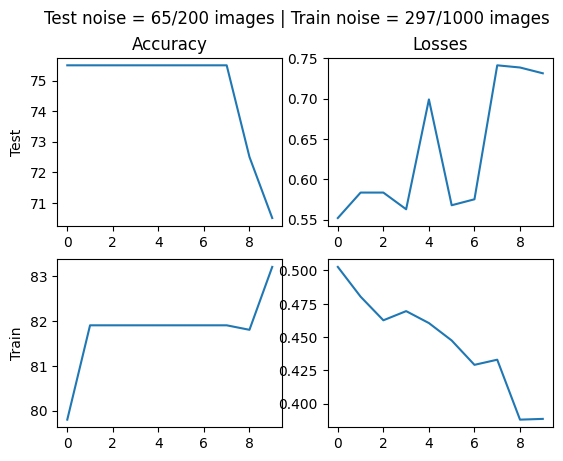

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0][0].plot(test_accs)
axes[0][0].set_title('Accuracy')
axes[0][0].set_ylabel('Test')
axes[0][1].plot(test_losses)
axes[0][1].set_title('Losses')
axes[1][0].plot(train_accs, label='Train Accuracy')
axes[1][0].set_ylabel('Train')
axes[1][1].plot(train_losses, label='Train Loss')
fig.suptitle(f"Test noise = {len(test_dataset.noise_indices)}/200 images | Train noise = {len(train_dataset.noise_indices)}/1000 images")
plt.show()

In [4]:
noises = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75]
best_acc_tv = []
def main():
  for n in noises:
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(n,0.1,0.1))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(n,0.1,0.1))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc_test = 0
    best_acc = 0
    for epoch in range(5):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')

        if test_acc > best_acc_test:
            best_acc_test = test_acc

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_tv_model_by_noise.pth')

    best_acc_tv.append(best_acc_test)


if __name__ == '__main__':
  main()

Validating: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch 1:
Train Loss: 0.5227, Train Acc: 78.60%
Val Loss: 0.5250, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch 2:
Train Loss: 0.5137, Train Acc: 78.90%
Val Loss: 0.5109, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]


Epoch 3:
Train Loss: 0.5104, Train Acc: 78.90%
Val Loss: 0.5331, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch 4:
Train Loss: 0.4988, Train Acc: 78.90%
Val Loss: 0.5323, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch 5:
Train Loss: 0.4702, Train Acc: 78.90%
Val Loss: 0.6148, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 1:
Train Loss: 0.5124, Train Acc: 80.70%
Val Loss: 0.4609, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 2:
Train Loss: 0.4759, Train Acc: 82.20%
Val Loss: 0.4836, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 3:
Train Loss: 0.4736, Train Acc: 82.20%
Val Loss: 0.4486, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch 4:
Train Loss: 0.4383, Train Acc: 82.20%
Val Loss: 0.5566, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 5:
Train Loss: 0.4445, Train Acc: 82.20%
Val Loss: 0.4809, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch 1:
Train Loss: 0.5198, Train Acc: 80.70%
Val Loss: 0.4881, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


Epoch 2:
Train Loss: 0.5052, Train Acc: 80.90%
Val Loss: 0.4647, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


Epoch 3:
Train Loss: 0.4885, Train Acc: 80.90%
Val Loss: 0.4424, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]


Epoch 4:
Train Loss: 0.4725, Train Acc: 80.90%
Val Loss: 0.4852, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


Epoch 5:
Train Loss: 0.4457, Train Acc: 80.90%
Val Loss: 0.5458, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 1:
Train Loss: 0.5160, Train Acc: 80.70%
Val Loss: 0.4637, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch 2:
Train Loss: 0.4713, Train Acc: 82.50%
Val Loss: 0.4969, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 3:
Train Loss: 0.4325, Train Acc: 82.50%
Val Loss: 0.6051, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]


Epoch 4:
Train Loss: 0.3870, Train Acc: 84.70%
Val Loss: 0.6782, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 5:
Train Loss: 0.4009, Train Acc: 83.90%
Val Loss: 0.6128, Val Acc: 69.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


Epoch 1:
Train Loss: 0.5134, Train Acc: 79.90%
Val Loss: 0.4951, Val Acc: 81.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 2:
Train Loss: 0.4610, Train Acc: 82.10%
Val Loss: 0.5233, Val Acc: 81.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch 3:
Train Loss: 0.4227, Train Acc: 82.10%
Val Loss: 0.9165, Val Acc: 81.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 4:
Train Loss: 0.4089, Train Acc: 83.60%
Val Loss: 1.3224, Val Acc: 81.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 5:
Train Loss: 0.3769, Train Acc: 83.90%
Val Loss: 1.3071, Val Acc: 81.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 1:
Train Loss: 0.5344, Train Acc: 77.90%
Val Loss: 0.4987, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 2:
Train Loss: 0.4905, Train Acc: 80.10%
Val Loss: 0.4955, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 3:
Train Loss: 0.4590, Train Acc: 80.20%
Val Loss: 0.7939, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


Epoch 4:
Train Loss: 0.4248, Train Acc: 81.50%
Val Loss: 0.7776, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 5:
Train Loss: 0.3450, Train Acc: 84.20%
Val Loss: 1.5431, Val Acc: 64.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 1:
Train Loss: 0.4929, Train Acc: 80.40%
Val Loss: 0.5544, Val Acc: 80.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 2:
Train Loss: 0.4533, Train Acc: 82.40%
Val Loss: 0.7124, Val Acc: 80.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 3:
Train Loss: 0.3716, Train Acc: 84.20%
Val Loss: 0.8068, Val Acc: 79.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch 4:
Train Loss: 0.3222, Train Acc: 87.70%
Val Loss: 0.8908, Val Acc: 64.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


Epoch 5:
Train Loss: 0.2868, Train Acc: 88.50%
Val Loss: 1.0831, Val Acc: 79.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 1:
Train Loss: 0.4944, Train Acc: 81.40%
Val Loss: 0.4912, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 2:
Train Loss: 0.4495, Train Acc: 81.40%
Val Loss: 0.5447, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch 3:
Train Loss: 0.4039, Train Acc: 83.10%
Val Loss: 0.6356, Val Acc: 81.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch 4:
Train Loss: 0.3080, Train Acc: 87.40%
Val Loss: 0.8314, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]


Epoch 5:
Train Loss: 0.2909, Train Acc: 87.90%
Val Loss: 3.6441, Val Acc: 47.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


Epoch 1:
Train Loss: 0.5462, Train Acc: 78.90%
Val Loss: 0.5287, Val Acc: 79.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]


Epoch 2:
Train Loss: 0.4155, Train Acc: 80.90%
Val Loss: 1.1437, Val Acc: 78.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch 3:
Train Loss: 0.3525, Train Acc: 85.50%
Val Loss: 1.2779, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 4:
Train Loss: 0.3113, Train Acc: 88.10%
Val Loss: 1.8708, Val Acc: 48.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch 5:
Train Loss: 0.2819, Train Acc: 88.70%
Val Loss: 1.3026, Val Acc: 79.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


Epoch 1:
Train Loss: 0.5018, Train Acc: 80.10%
Val Loss: 0.5681, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 2:
Train Loss: 0.3625, Train Acc: 82.00%
Val Loss: 0.9680, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 3:
Train Loss: 0.2264, Train Acc: 91.20%
Val Loss: 1.4990, Val Acc: 45.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


Epoch 4:
Train Loss: 0.2005, Train Acc: 92.00%
Val Loss: 1.0016, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 5:
Train Loss: 0.1942, Train Acc: 92.30%
Val Loss: 1.2581, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 1:
Train Loss: 0.5198, Train Acc: 78.90%
Val Loss: 0.4504, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 2:
Train Loss: 0.3615, Train Acc: 83.10%
Val Loss: 1.2967, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 3:
Train Loss: 0.2193, Train Acc: 92.40%
Val Loss: 1.3055, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch 4:
Train Loss: 0.2357, Train Acc: 92.30%
Val Loss: 0.9966, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

Epoch 5:
Train Loss: 0.2132, Train Acc: 92.40%
Val Loss: 1.3654, Val Acc: 61.50%


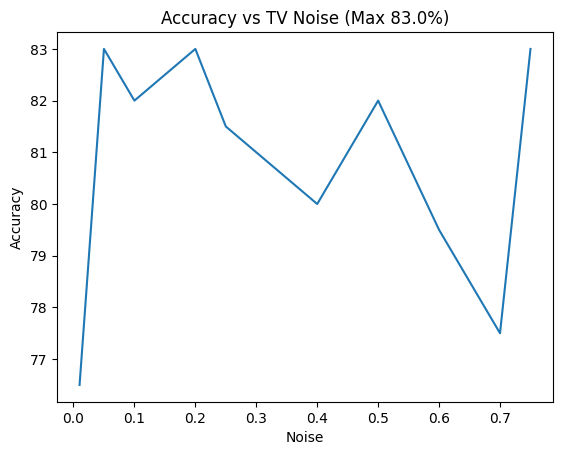

In [5]:
plt.plot(noises, best_acc_tv)
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs TV Noise (Max {max(best_acc_tv)}%)')
plt.show()

In [6]:
noises = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75]
best_acc_shape = []
def main():
  for n in noises:
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(0.1,n,0.1))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(0.1,n,0.1))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc_test = 0
    best_acc = 0
    for epoch in range(5):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')

        if test_acc > best_acc_test:
            best_acc_test = test_acc

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_shape_model_by_noise.pth')

    best_acc_shape.append(best_acc_test)


if __name__ == '__main__':
  main()

Validating: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch 1:
Train Loss: 0.3631, Train Acc: 90.10%
Val Loss: 0.3400, Val Acc: 88.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 2:
Train Loss: 0.3038, Train Acc: 91.10%
Val Loss: 0.3647, Val Acc: 88.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


Epoch 3:
Train Loss: 0.2882, Train Acc: 91.10%
Val Loss: 0.3897, Val Acc: 88.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 4:
Train Loss: 0.2766, Train Acc: 91.10%
Val Loss: 0.3971, Val Acc: 88.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]


Epoch 5:
Train Loss: 0.2581, Train Acc: 91.10%
Val Loss: 0.5199, Val Acc: 88.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch 1:
Train Loss: 0.4718, Train Acc: 83.10%
Val Loss: 0.4380, Val Acc: 85.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 2:
Train Loss: 0.4095, Train Acc: 85.10%
Val Loss: 0.4596, Val Acc: 85.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 3:
Train Loss: 0.4134, Train Acc: 85.10%
Val Loss: 0.4303, Val Acc: 85.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 4:
Train Loss: 0.3878, Train Acc: 85.10%
Val Loss: 0.5070, Val Acc: 85.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 5:
Train Loss: 0.3770, Train Acc: 85.10%
Val Loss: 0.4572, Val Acc: 85.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 1:
Train Loss: 0.5419, Train Acc: 78.70%
Val Loss: 0.5016, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch 2:
Train Loss: 0.5150, Train Acc: 79.60%
Val Loss: 0.4946, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 3:
Train Loss: 0.4949, Train Acc: 79.60%
Val Loss: 0.5574, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch 4:
Train Loss: 0.4849, Train Acc: 79.60%
Val Loss: 0.5093, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


Epoch 5:
Train Loss: 0.4840, Train Acc: 79.60%
Val Loss: 0.4911, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


Epoch 1:
Train Loss: 0.5724, Train Acc: 75.00%
Val Loss: 0.5765, Val Acc: 74.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch 2:
Train Loss: 0.5713, Train Acc: 75.10%
Val Loss: 0.5894, Val Acc: 74.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch 3:
Train Loss: 0.5523, Train Acc: 75.10%
Val Loss: 0.7216, Val Acc: 74.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch 4:
Train Loss: 0.5508, Train Acc: 75.10%
Val Loss: 0.6901, Val Acc: 74.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 5:
Train Loss: 0.5569, Train Acc: 75.10%
Val Loss: 0.6195, Val Acc: 74.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


Epoch 1:
Train Loss: 0.6634, Train Acc: 65.80%
Val Loss: 0.6636, Val Acc: 65.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 2:
Train Loss: 0.6227, Train Acc: 68.20%
Val Loss: 0.6694, Val Acc: 65.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]


Epoch 3:
Train Loss: 0.6218, Train Acc: 68.20%
Val Loss: 0.6805, Val Acc: 65.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 4:
Train Loss: 0.6266, Train Acc: 68.20%
Val Loss: 0.6642, Val Acc: 65.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


Epoch 5:
Train Loss: 0.6094, Train Acc: 68.20%
Val Loss: 0.6771, Val Acc: 65.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.22it/s]


Epoch 1:
Train Loss: 0.6716, Train Acc: 63.10%
Val Loss: 0.6423, Val Acc: 64.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 2:
Train Loss: 0.6612, Train Acc: 63.50%
Val Loss: 0.6489, Val Acc: 64.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 3:
Train Loss: 0.6492, Train Acc: 63.50%
Val Loss: 0.6446, Val Acc: 64.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


Epoch 4:
Train Loss: 0.6587, Train Acc: 63.50%
Val Loss: 0.6371, Val Acc: 64.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


Epoch 5:
Train Loss: 0.6426, Train Acc: 63.50%
Val Loss: 0.7527, Val Acc: 64.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch 1:
Train Loss: 0.6977, Train Acc: 50.40%
Val Loss: 0.6882, Val Acc: 56.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 2:
Train Loss: 0.6920, Train Acc: 52.80%
Val Loss: 0.6897, Val Acc: 56.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 3:
Train Loss: 0.6833, Train Acc: 53.60%
Val Loss: 0.6883, Val Acc: 58.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Epoch 4:
Train Loss: 0.6867, Train Acc: 54.70%
Val Loss: 0.6919, Val Acc: 61.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 5:
Train Loss: 0.6721, Train Acc: 58.30%
Val Loss: 0.7645, Val Acc: 58.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 1:
Train Loss: 0.6959, Train Acc: 55.60%
Val Loss: 0.6962, Val Acc: 50.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 2:
Train Loss: 0.6855, Train Acc: 56.00%
Val Loss: 0.7165, Val Acc: 52.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 3:
Train Loss: 0.6735, Train Acc: 58.40%
Val Loss: 0.7318, Val Acc: 51.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 4:
Train Loss: 0.6677, Train Acc: 59.90%
Val Loss: 0.7096, Val Acc: 52.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 5:
Train Loss: 0.6655, Train Acc: 58.00%
Val Loss: 0.6963, Val Acc: 47.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch 1:
Train Loss: 0.6614, Train Acc: 63.60%
Val Loss: 0.6717, Val Acc: 59.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 2:
Train Loss: 0.6520, Train Acc: 64.60%
Val Loss: 0.8174, Val Acc: 59.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 3:
Train Loss: 0.6362, Train Acc: 64.60%
Val Loss: 0.7002, Val Acc: 59.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch 4:
Train Loss: 0.6357, Train Acc: 64.60%
Val Loss: 0.7356, Val Acc: 59.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 5:
Train Loss: 0.6293, Train Acc: 64.60%
Val Loss: 0.7601, Val Acc: 60.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch 1:
Train Loss: 0.5959, Train Acc: 72.40%
Val Loss: 0.6688, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 2:
Train Loss: 0.5863, Train Acc: 72.50%
Val Loss: 0.5617, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


Epoch 3:
Train Loss: 0.5655, Train Acc: 72.50%
Val Loss: 0.6052, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.53it/s]


Epoch 4:
Train Loss: 0.5679, Train Acc: 72.50%
Val Loss: 0.7403, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]


Epoch 5:
Train Loss: 0.5537, Train Acc: 72.50%
Val Loss: 0.6684, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 1:
Train Loss: 0.5316, Train Acc: 78.00%
Val Loss: 0.6851, Val Acc: 72.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


Epoch 2:
Train Loss: 0.5436, Train Acc: 78.00%
Val Loss: 0.6998, Val Acc: 72.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch 3:
Train Loss: 0.5168, Train Acc: 78.00%
Val Loss: 0.6774, Val Acc: 72.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]


Epoch 4:
Train Loss: 0.5104, Train Acc: 78.00%
Val Loss: 0.6703, Val Acc: 72.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]

Epoch 5:
Train Loss: 0.4976, Train Acc: 78.00%
Val Loss: 0.6327, Val Acc: 72.00%


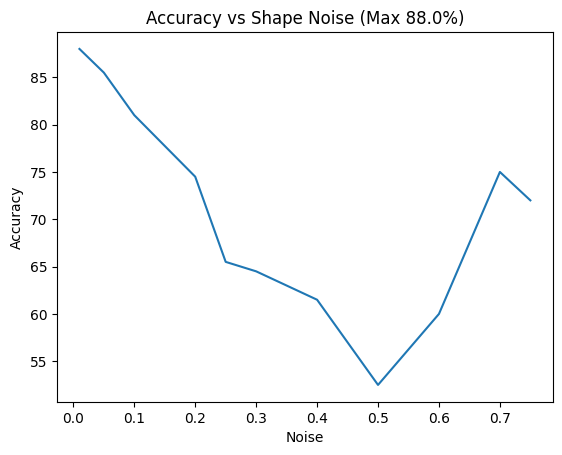

In [7]:
plt.plot(noises, best_acc_shape)
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Shape Noise (Max {max(best_acc_shape)}%)')
plt.show()

In [8]:
noises = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75]
best_acc_color = []
def main():
  for n in noises:
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(0.1,0.1,n))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(0.1,0.1,n))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc_test = 0
    best_acc = 0
    for epoch in range(5):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')

        if test_acc > best_acc_test:
            best_acc_test = test_acc

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_color_model_by_noise.pth')

    best_acc_color.append(best_acc_test)


if __name__ == '__main__':
  main()

Validating: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch 1:
Train Loss: 0.3832, Train Acc: 88.00%
Val Loss: 0.3447, Val Acc: 90.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 2:
Train Loss: 0.3254, Train Acc: 90.40%
Val Loss: 0.4445, Val Acc: 90.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch 3:
Train Loss: 0.2924, Train Acc: 90.40%
Val Loss: 0.4885, Val Acc: 90.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 4:
Train Loss: 0.2803, Train Acc: 90.40%
Val Loss: 0.3609, Val Acc: 90.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]


Epoch 5:
Train Loss: 0.2746, Train Acc: 90.40%
Val Loss: 0.4864, Val Acc: 90.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 1:
Train Loss: 0.4153, Train Acc: 86.20%
Val Loss: 0.4596, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


Epoch 2:
Train Loss: 0.3747, Train Acc: 87.00%
Val Loss: 0.4956, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 3:
Train Loss: 0.3534, Train Acc: 87.00%
Val Loss: 0.9568, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch 4:
Train Loss: 0.3531, Train Acc: 87.00%
Val Loss: 0.5094, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


Epoch 5:
Train Loss: 0.3319, Train Acc: 87.00%
Val Loss: 0.5651, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


Epoch 1:
Train Loss: 0.5111, Train Acc: 80.10%
Val Loss: 0.5311, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 2:
Train Loss: 0.5003, Train Acc: 80.80%
Val Loss: 0.5723, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


Epoch 3:
Train Loss: 0.4982, Train Acc: 80.80%
Val Loss: 0.5878, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 4:
Train Loss: 0.4607, Train Acc: 80.80%
Val Loss: 0.5183, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 5:
Train Loss: 0.4754, Train Acc: 80.80%
Val Loss: 0.5593, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]


Epoch 1:
Train Loss: 0.6143, Train Acc: 70.20%
Val Loss: 0.6265, Val Acc: 69.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 2:
Train Loss: 0.5992, Train Acc: 71.60%
Val Loss: 0.6507, Val Acc: 69.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]


Epoch 3:
Train Loss: 0.5959, Train Acc: 71.60%
Val Loss: 0.6732, Val Acc: 69.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch 4:
Train Loss: 0.5855, Train Acc: 71.60%
Val Loss: 0.6895, Val Acc: 69.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 5:
Train Loss: 0.5555, Train Acc: 71.60%
Val Loss: 0.6829, Val Acc: 69.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.23it/s]


Epoch 1:
Train Loss: 0.6474, Train Acc: 66.20%
Val Loss: 0.6643, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


Epoch 2:
Train Loss: 0.6385, Train Acc: 67.40%
Val Loss: 0.6721, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch 3:
Train Loss: 0.6309, Train Acc: 67.20%
Val Loss: 0.6377, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch 4:
Train Loss: 0.6177, Train Acc: 68.10%
Val Loss: 0.7060, Val Acc: 56.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Epoch 5:
Train Loss: 0.6052, Train Acc: 67.30%
Val Loss: 0.6982, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch 1:
Train Loss: 0.6803, Train Acc: 61.20%
Val Loss: 0.6230, Val Acc: 67.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 2:
Train Loss: 0.6672, Train Acc: 59.20%
Val Loss: 0.6195, Val Acc: 67.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 3:
Train Loss: 0.6632, Train Acc: 61.80%
Val Loss: 0.6223, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 4:
Train Loss: 0.6651, Train Acc: 61.20%
Val Loss: 0.6247, Val Acc: 67.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch 5:
Train Loss: 0.6666, Train Acc: 61.20%
Val Loss: 0.6428, Val Acc: 67.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch 1:
Train Loss: 0.7043, Train Acc: 50.60%
Val Loss: 0.6962, Val Acc: 50.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch 2:
Train Loss: 0.6924, Train Acc: 53.00%
Val Loss: 0.6968, Val Acc: 51.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 3:
Train Loss: 0.6892, Train Acc: 55.30%
Val Loss: 0.7435, Val Acc: 50.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


Epoch 4:
Train Loss: 0.6914, Train Acc: 55.50%
Val Loss: 0.7017, Val Acc: 46.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


Epoch 5:
Train Loss: 0.6915, Train Acc: 53.00%
Val Loss: 0.7044, Val Acc: 50.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]


Epoch 1:
Train Loss: 0.6969, Train Acc: 53.40%
Val Loss: 0.6925, Val Acc: 52.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


Epoch 2:
Train Loss: 0.6926, Train Acc: 54.30%
Val Loss: 0.6946, Val Acc: 53.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 3:
Train Loss: 0.6908, Train Acc: 56.20%
Val Loss: 0.6872, Val Acc: 54.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


Epoch 4:
Train Loss: 0.6854, Train Acc: 55.90%
Val Loss: 0.6965, Val Acc: 49.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 5:
Train Loss: 0.6896, Train Acc: 55.00%
Val Loss: 0.6889, Val Acc: 54.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch 1:
Train Loss: 0.6586, Train Acc: 64.00%
Val Loss: 0.6891, Val Acc: 62.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 2:
Train Loss: 0.6447, Train Acc: 65.10%
Val Loss: 0.6611, Val Acc: 61.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 3:
Train Loss: 0.6504, Train Acc: 65.40%
Val Loss: 0.6698, Val Acc: 62.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]


Epoch 4:
Train Loss: 0.6284, Train Acc: 65.10%
Val Loss: 0.9360, Val Acc: 62.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch 5:
Train Loss: 0.6351, Train Acc: 64.20%
Val Loss: 0.7035, Val Acc: 62.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


Epoch 1:
Train Loss: 0.6023, Train Acc: 71.40%
Val Loss: 0.6097, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


Epoch 2:
Train Loss: 0.5825, Train Acc: 73.40%
Val Loss: 0.5917, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


Epoch 3:
Train Loss: 0.5564, Train Acc: 73.40%
Val Loss: 0.6006, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 4:
Train Loss: 0.5512, Train Acc: 73.40%
Val Loss: 0.5762, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.44it/s]


Epoch 5:
Train Loss: 0.5441, Train Acc: 73.10%
Val Loss: 0.6380, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


Epoch 1:
Train Loss: 0.5501, Train Acc: 77.30%
Val Loss: 0.5549, Val Acc: 77.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


Epoch 2:
Train Loss: 0.5278, Train Acc: 78.10%
Val Loss: 0.5447, Val Acc: 77.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


Epoch 3:
Train Loss: 0.5122, Train Acc: 78.10%
Val Loss: 0.6478, Val Acc: 77.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 4:
Train Loss: 0.5034, Train Acc: 78.10%
Val Loss: 0.6146, Val Acc: 77.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]

Epoch 5:
Train Loss: 0.4956, Train Acc: 78.10%
Val Loss: 0.5789, Val Acc: 77.00%


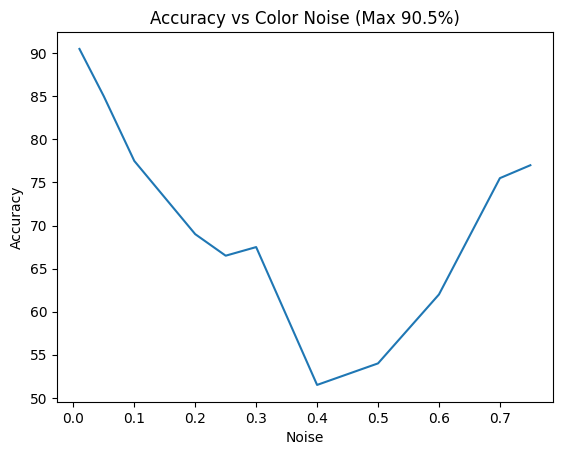

In [9]:
plt.plot(noises, best_acc_color)
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Color Noise (Max {max(best_acc_color)}%)')
plt.show()

In [10]:
best_acc_overall = []
def main():
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(0.25,0.01,0.01))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(0.25, 0.01, 0.01))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc = 0
    for epoch in range(10):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_overall.pth')

        best_acc_overall.append(test_acc)


if __name__ == '__main__':
  main()

Validating: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 1:
Train Loss: 0.1587, Train Acc: 95.40%
Val Loss: 0.1585, Test Acc: 97.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 2:
Train Loss: 0.0847, Train Acc: 98.10%
Val Loss: 0.2415, Test Acc: 97.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch 3:
Train Loss: 0.0693, Train Acc: 98.10%
Val Loss: 0.2607, Test Acc: 97.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 4:
Train Loss: 0.0546, Train Acc: 98.10%
Val Loss: 0.3724, Test Acc: 97.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 5:
Train Loss: 0.0667, Train Acc: 98.30%
Val Loss: 0.4764, Test Acc: 97.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


Epoch 6:
Train Loss: 0.0675, Train Acc: 98.60%
Val Loss: 0.3933, Test Acc: 97.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 7:
Train Loss: 0.0644, Train Acc: 98.20%
Val Loss: 0.2761, Test Acc: 97.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 8:
Train Loss: 0.0414, Train Acc: 98.40%
Val Loss: 0.2624, Test Acc: 97.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


Epoch 9:
Train Loss: 0.0203, Train Acc: 99.30%
Val Loss: 0.4456, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]

Epoch 10:
Train Loss: 0.0337, Train Acc: 99.00%
Val Loss: 0.8566, Test Acc: 79.50%


In [11]:
print(max(best_acc_overall))

97.5


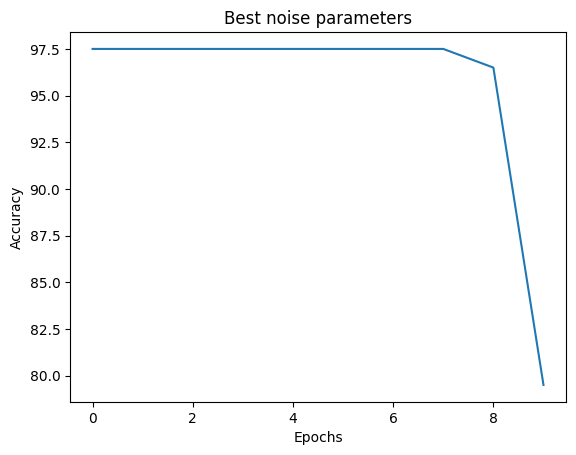

In [12]:
plt.plot(best_acc_overall)
plt.title("Best noise parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()